# Determining the cost of cars

The used car sales service is developing an application to attract new customers. In this app, users will be able to quickly find out the market value of their car. There is historical data, including technical specifications, configurations, and prices of cars. 

**Project objective**
Your task is to build a model for determining the car's value.

The client values:
* Prediction accuracy
* Prediction speed
* Training time.

**Data description**

*Features*
* `DateCrawled` — date of downloading the questionnaire from the database
* `VehicleType` — type of car body
* `RegistrationYear` — the year of registration of the car
* `Gearbox` — type of gearbox
* `Power` — power (hp)
* `Model` — car model
* `Kilometer` — mileage (km)
* `RegistrationMonth` — month of car registration
* `FuelType` — fuel type
* `Brand` — car brand
* `Repaired` — was the car under repair or not
* `DateCreated` — date of creation of the questionnaire
* `NumberOfPictures` — the number of photos of the car
* `PostalCode` — postal code of the questionnaire owner (user)
* `lastSeen` — the date of the user's last activity

*Target attribute*
* `Price` — price (Euro)

**Content of Table**
1. Data preparation \
1.1 General analysis \
1.2 Processing of omissions \
1.3 Removing anomalies 


Loading all the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import catboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgbm

## Data preparation

In [2]:
data = pd.read_csv('/Users/aasheremeeva/Desktop/All DS Projects/cost of cars/autos.csv')

### General analysis

In [3]:
def general_analysis(data):
    print(data.info())
    print('__________________________________________________________________________________________________________')
    print(display(data.head(10)))
    print('__________________________________________________________________________________________________________')
    print(display(data[['Price','Power','Kilometer']].describe()))
    print('__________________________________________________________________________________________________________')
    print('# of missing values:')
    print(data.isna().sum())
    print('__________________________________________________________________________________________________________')
    print('# of dublicates:')
    print(data.duplicated().sum())
    print('__________________________________________________________________________________________________________')

In [4]:
general_analysis(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


None
__________________________________________________________________________________________________________


,Price,Power,Kilometer
count,354369.000000,354369.000000,354369.000000
mean,4416.656776,110.094337,128211.172535
std,4514.158514,189.850405,37905.341530
min,0.000000,0.000000,5000.000000
25%,1050.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6400.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


None
__________________________________________________________________________________________________________
# of missing values:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
__________________________________________________________________________________________________________
# of dublicates:
4
__________________________________________________________________________________________________________


In [5]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Based on the initial analysis, it can be noticed that there are quite a large number of variables in the dataset, most of which are categorical, and also have a significant number of omissions.

### Processing of omissions

In the final dataset , omissions are observed in the following variables:
* VehicleType 
* Gearbox
* Model
* FuelType
* Repaired

In [6]:
print(data['VehicleType'].unique())
print()
print(data['Gearbox'].unique())
print()
print(data['Model'].unique())
print()
print(data['FuelType'].unique())
print()
print(data['Repaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

['manual' 'auto' nan]

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' '

1. **Vehicle Type, vehicle type**\
The missing values of the car type can be restored by other lines of the dataframe. 

2. **Gearbox, box type**\
We will replace the missing values with the most frequently encountered type in the dataset. 

3. **Model, car model**\
We will replace the missing values with a separate unknown category.

4. **FuelType, fuel type**\
The missing fuel type values can be restored using other dataframe lines. 

5. **Repaired, has it been repaired**\
Let's say if the deposit is not filled, then the car has not been repaired.

In [7]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [8]:
data.fillna({'Gearbox':'manual', 'Repaired':'no','Model':'unknown'},inplace=True)
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
data[['VehicleType','Model','FuelType']].head(30)

,VehicleType,Model,FuelType
0,NaN,golf,petrol
1,coupe,unknown,gasoline
2,suv,grand,gasoline
3,small,golf,petrol
4,small,fabia,gasoline
5,sedan,3er,petrol
6,convertible,2_reihe,petrol
7,sedan,other,petrol
8,bus,c_max,petrol
9,small,golf,NaN


In [10]:
veh_type_model = data.groupby('Model')['VehicleType'].first()
data['VehicleType'] = data['VehicleType'].fillna(data['Model'].map(veh_type_model))

In [11]:
data['VehicleType'].isna().sum()

0

In [12]:
fuel_model = data.groupby('Model')['FuelType'].first()
data['FuelType'] = data['FuelType'].fillna(data['Model'].map(fuel_model))

In [13]:
data['FuelType'].isna().sum()

0

In [14]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

As a result, there were no gaps left in the data.

### Removing anomalies

Histograms for some parameters are plotted below.

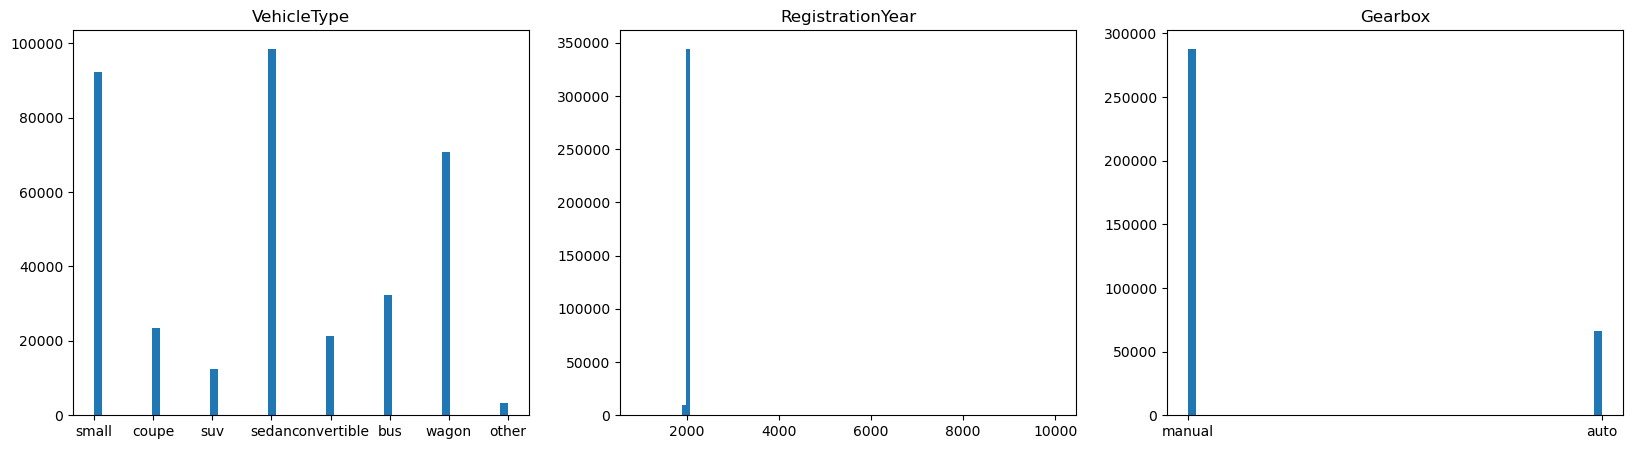

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].hist(data['VehicleType'], bins=50)
axs[0].set_title('VehicleType')

axs[1].hist(data['RegistrationYear'], bins=100)
axs[1].set_title('RegistrationYear')

axs[2].hist(data['Gearbox'], bins=50)
axs[2].set_title('Gearbox')
plt.show()

From the first graphs it can be seen that emissions are observed in the variable with the year of registration. We will find when the extreme ads were uploaded.

In [16]:
date_crawled = pd.to_datetime(data['DateCrawled'])
print(date_crawled.max())

2016-04-07 14:36:58


Axes(0.125,0.11;0.775x0.77)


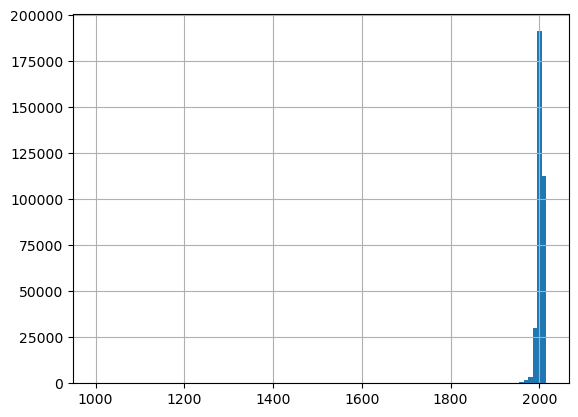

In [17]:
data = data.query('RegistrationYear < 2017')
print(data['RegistrationYear'].hist(bins=100))
plt.show()

Axes(0.125,0.11;0.775x0.77)


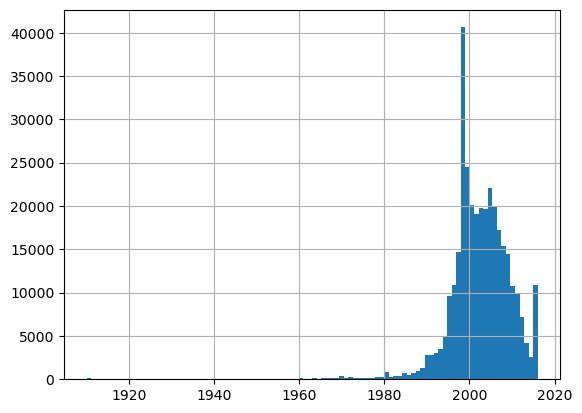

In [18]:
data = data.query('1900 < RegistrationYear')
print(data['RegistrationYear'].hist(bins=100))
plt.show()

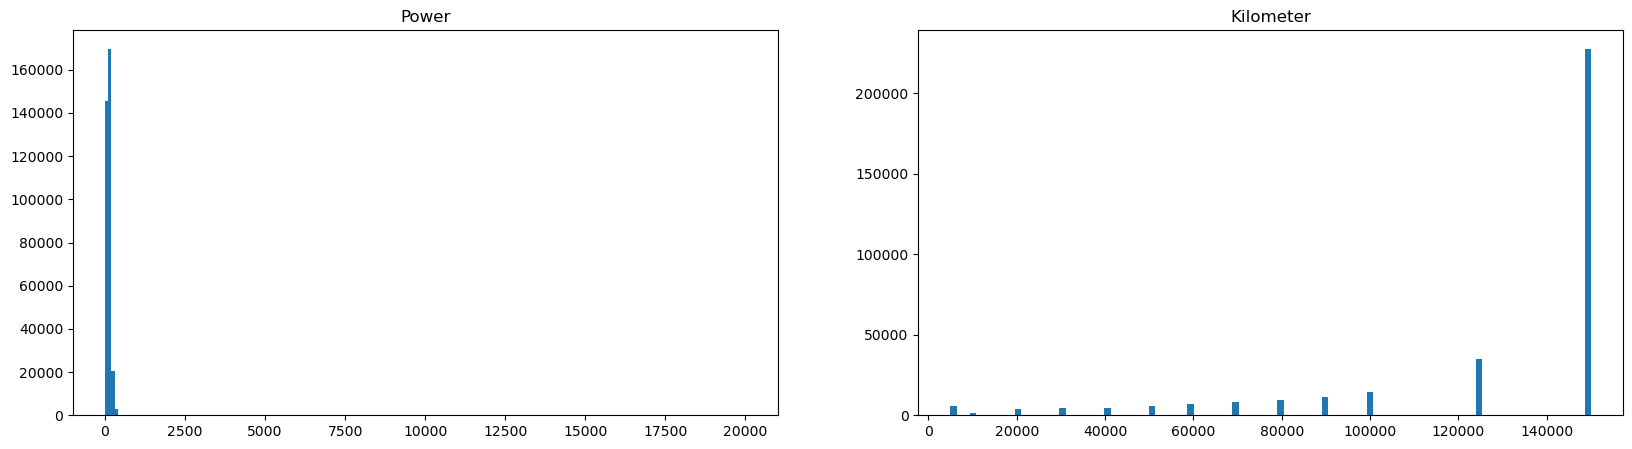

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].hist(data['Power'], bins=200)
axs[0].set_title('Power')

axs[1].hist(data['Kilometer'], bins=100)
axs[1].set_title('Kilometer')
plt.show()

Axes(0.125,0.11;0.775x0.77)


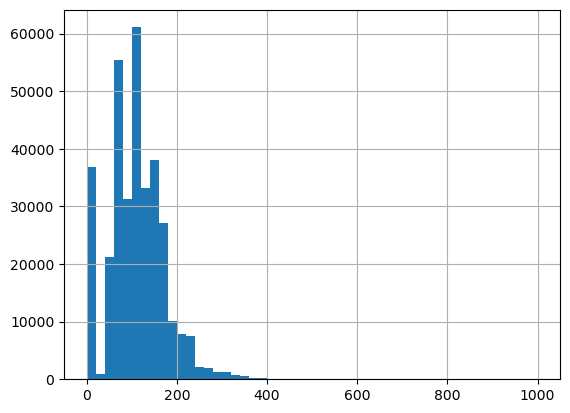

In [20]:
data = data.query('Power < 1001')
print(data['Power'].hist(bins=50))
plt.show()

There should be no zero values in the Power parameter, so they are then deleted.

Axes(0.125,0.11;0.775x0.77)


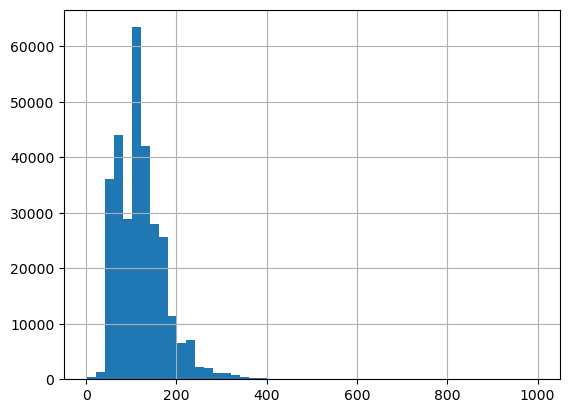

In [21]:
data = data.query('0 < Power')
print(data['Power'].hist(bins=50))

Axes(0.125,0.11;0.775x0.77)


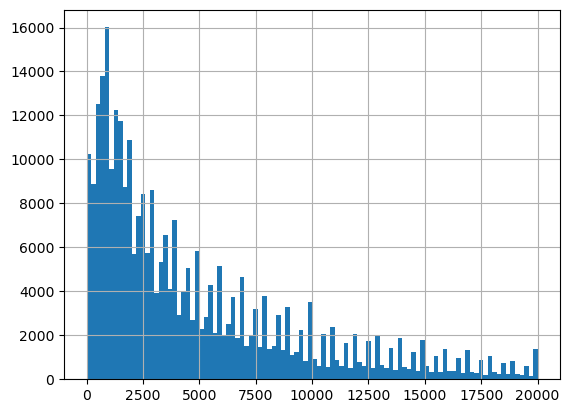

In [22]:
print(data['Price'].hist(bins=100))

In [23]:
data['Price'].value_counts()

0        6406
500      4475
1500     4431
1200     3737
2500     3707
         ... 
3021        1
1368        1
233         1
11080       1
10985       1
Name: Price, Length: 3592, dtype: int64

At the same time, a sufficiently large number of zero values are observed in the target variable, it is necessary to delete them.

In [24]:
data = data.query('Price > 0')
data['Price'].value_counts()

500      4475
1500     4431
1200     3737
2500     3707
1000     3612
         ... 
3021        1
1368        1
233         1
11080       1
10985       1
Name: Price, Length: 3591, dtype: int64

What variables affect the market value of a car? 

* Vehicle Type - body type
* RegistrationYear - the year of car registration
* Gearbox - type of gearbox
* Power - power
* Model - model
* Kilometer - mileage
* FuelType - fuel type
* Brand - brand
* Repaired - if the car was repaired

The remaining variables can be deleted.

In [25]:
data = data.drop(columns = ['DateCrawled','RegistrationMonth','DateCreated',
                            'NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [26]:
print(data['VehicleType'].unique())
print()
print(data['Gearbox'].unique())
print()
print(data['Model'].unique())
print()
print(data['Brand'].unique())
print()
print(data['FuelType'].unique())
print()
print(data['Repaired'].unique())

['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

['manual' 'auto']

['unknown' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa'
 'other' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one'
 'fortwo' '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' 'astra' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka'
 'a1' 'focus' 'a4' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe'
 'sharan' 'avensis' 'roomster' 'sl' 'kaefer' 

In [27]:
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


As a result, we have two variables that can be converted to binary (Gearbox and Repaired).

In [28]:
data['Gearbox'].loc[data['Gearbox'] == 'manual'] = 1
data['Gearbox'].loc[data['Gearbox'] == 'auto'] = 0
data['Gearbox'].value_counts()

/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_44205/2244569903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gearbox'].loc[data['Gearbox'] == 'manual'] = 1
/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_44205/2244569903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gearbox'].loc[data['Gearbox'] == 'auto'] = 0


1    237682
0     58955
Name: Gearbox, dtype: int64

In [29]:
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,1,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,0,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,1,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,1,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,1,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,1,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,1,125,c_max,30000,petrol,ford,no
9,999,small,1998,1,101,golf,150000,petrol,volkswagen,no
10,2000,sedan,2004,1,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,1,140,passat,150000,gasoline,volkswagen,yes


In [30]:
data['Repaired'].loc[data['Repaired'] == 'yes'] = 1
data['Repaired'].loc[data['Repaired'] == 'no'] = 0
data['Repaired'].value_counts()

/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_44205/2987993552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Repaired'].loc[data['Repaired'] == 'yes'] = 1
/var/folders/s9/2dhk92k53t10g5010dcth9r80000gn/T/ipykernel_44205/2987993552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Repaired'].loc[data['Repaired'] == 'no'] = 0


0    267681
1     28956
Name: Repaired, dtype: int64

In [31]:
data['Gearbox'] = pd.to_numeric(data['Gearbox'], downcast='integer')
data['Repaired'] = pd.to_numeric(data['Repaired'], downcast='integer')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296637 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296637 non-null  int64 
 1   VehicleType       296637 non-null  object
 2   RegistrationYear  296637 non-null  int64 
 3   Gearbox           296637 non-null  int8  
 4   Power             296637 non-null  int64 
 5   Model             296637 non-null  object
 6   Kilometer         296637 non-null  int64 
 7   FuelType          296637 non-null  object
 8   Brand             296637 non-null  object
 9   Repaired          296637 non-null  int8  
dtypes: int64(4), int8(2), object(4)
memory usage: 20.9+ MB


### Conclusion

During the data analysis , it was possible: 
- Get a general idea of the data. 
- Get rid of the omissions in the most optimal way.
- Get rid of anomalies in the data. 
- Remove unnecessary variables that will not be relevant for building models in the following parts.

## Model training

### Preparing samples

In [33]:
y = data['Price']
X = data.drop('Price', axis=1)

Separation of all data into training and test samples.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,  test_size=0.2, random_state= 42) 

In [35]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(189847, 9)
(47462, 9)
(59328, 9)
(189847,)
(47462,)
(59328,)


In [36]:
#standardizing
numeric=['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric]=scaler.transform(X_train[numeric])
X_train_scaled = pd.DataFrame(X_train[numeric], columns = numeric, index = X_train.index)

X_valid[numeric]=scaler.transform(X_valid[numeric])
X_valid_scaled = pd.DataFrame(X_valid[numeric], columns = numeric, index = X_valid.index)

X_test[numeric]=scaler.transform(X_test[numeric])
X_test_scaled = pd.DataFrame(X_test[numeric], columns = numeric, index = X_test.index)

One Hot Encoding and Dummy Encoding will be used to prepare categorical variables for a linear regression model. 
Which variables are categorical:
* Vehicle Type - body type
* Gearbox - type of gearbox
* Model - model
* FuelType - fuel type
* Brand - brand
* Repaired - has the car been repaired

In [37]:
cats=['VehicleType','Model','FuelType','Brand']
ohs = OneHotEncoder(drop='first')
X_train_ohs = pd.DataFrame(ohs.fit_transform(X_train[['VehicleType','Model','FuelType','Brand']]).toarray(),columns = ohs.get_feature_names_out())
X_valid_ohs = pd.DataFrame(ohs.transform(X_valid[['VehicleType','Model','FuelType','Brand']]).toarray(), columns = ohs.get_feature_names_out())
X_test_ohs = pd.DataFrame(ohs.transform(X_test[['VehicleType','Model','FuelType','Brand']]).toarray(), columns = ohs.get_feature_names_out())

In [38]:
X_train_final = pd.concat([X_train_scaled.reset_index(), X_train_ohs.reset_index()], axis = 1)
X_valid_final = pd.concat([X_valid_scaled.reset_index(), X_valid_ohs.reset_index()], axis = 1)
X_test_final = pd.concat([X_test_scaled.reset_index(), X_test_ohs.reset_index()], axis = 1)

In [39]:
enc = OrdinalEncoder()
X_train_oe_cat = enc.fit_transform(X_train[['VehicleType','FuelType','Brand','Model']])
X_valid_oe_cat = enc.transform(X_valid[['VehicleType','FuelType','Brand','Model']])
X_test_oe_cat = enc.transform(X_test[['VehicleType','FuelType','Brand','Model']])

In [40]:
X_train_oe = X_train.copy()
X_train_oe[['VehicleType','FuelType','Brand','Model']] = X_train_oe_cat

X_valid_oe = X_valid.copy()
X_valid_oe[['VehicleType','FuelType','Brand','Model']] = X_valid_oe_cat

X_test_oe = X_test.copy()
X_test_oe[['VehicleType','FuelType','Brand','Model']] = X_test_oe_cat

As a result, it was possible to prepare all categorical variables so that they could be used in the models below.

### Model training and testing

What models will we considered:
* Linear regression
* LightGBM
* CatBoostRegressor

#### LinearRegression

In [41]:
%%time

regressor = LinearRegression()
RMSE_linear = (cross_val_score(regressor, X_train_final, y_train, cv=5,
                               scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE for linear regression =', RMSE_linear)

Mean RMSE for linear regression = 2728.477305060425
CPU times: user 1min 24s, sys: 1min 19s, total: 2min 44s
Wall time: 58.1 s


In [42]:
%%time

model = LinearRegression()
model.fit(X_train_final, y_train)

CPU times: user 22.6 s, sys: 20.3 s, total: 42.9 s
Wall time: 12.5 s


LinearRegression()

In [43]:
%%time

y_pred_linear_valid = model.predict(X_valid_final)

CPU times: user 211 ms, sys: 606 ms, total: 817 ms
Wall time: 213 ms


In [44]:
RMSE_Linear = mean_squared_error(y_valid, y_pred_linear_valid) ** 0.5
print(RMSE_Linear)

2702.6000788782308


#### LightGBM

In [45]:
%%time

model_lgbm = LGBMRegressor() 
params_lgbm = [{'num_leaves':[50, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]}]

lgbm_gs = GridSearchCV(model_lgbm, params_lgbm, scoring='neg_mean_squared_error')
lgbm_gs.fit(X_train_oe, y_train)

print(lgbm_gs.best_params_)

means = lgbm_gs.cv_results_['mean_test_score']
RMSE_lgbm_cv = (max(means)*-1) ** 0.5
print(RMSE_lgbm_cv)

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 42}
1589.748677643851
CPU times: user 8min, sys: 1min 31s, total: 9min 32s
Wall time: 2min 7s


In [46]:
%%time

model_lgbm_best = LGBMRegressor(learning_rate=0.3,num_leaves=200, random_state=42)
model_lgbm_best.fit(X_train_oe, y_train)

CPU times: user 16.8 s, sys: 3.42 s, total: 20.2 s
Wall time: 4.63 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=42)

In [47]:
%%time

y_predict_lgbm_valid = model_lgbm_best.predict(X_valid_oe)

CPU times: user 751 ms, sys: 41.3 ms, total: 792 ms
Wall time: 174 ms


In [48]:
RMSE_lgbm = mean_squared_error(y_valid, y_predict_lgbm_valid) ** 0.5
print(RMSE_lgbm)

1531.5606799264474


#### CatBoostRegressor

In [49]:
%%time

model_cb = CatBoostRegressor() 
params_cb = [{'learning_rate':[0.1, 0.5, 0.9],
                'random_state':[42],
                'verbose':[0]}]

cb = GridSearchCV(model_cb, params_cb, scoring='neg_mean_squared_error')
cb.fit(X_train_oe, y_train)

print(cb.best_params_)

means = cb.cv_results_['mean_test_score']
RMSE_cb_cv = (max(means)*-1) ** 0.5
print(RMSE_cb_cv)

{'learning_rate': 0.5, 'random_state': 42, 'verbose': 0}
1606.3238105548546
CPU times: user 6min 54s, sys: 1min 14s, total: 8min 8s
Wall time: 2min 24s


In [50]:
%%time

model_cb_best = CatBoostRegressor(learning_rate=0.5, random_state=42, verbose=0) 
model_cb_best.fit(X_train_oe, y_train)

CPU times: user 31.8 s, sys: 4.89 s, total: 36.7 s
Wall time: 10.9 s


In [51]:
%%time

y_predict_cb_valid = model_cb_best.predict(X_valid_oe)

CPU times: user 60.8 ms, sys: 12.1 ms, total: 72.8 ms
Wall time: 35.6 ms


In [52]:
RMSE_cb = mean_squared_error(y_valid, y_predict_cb_valid) ** 0.5
print(RMSE_cb)

1551.3626230764282


## Model analysis

Let's compare the training and prediction time of the models, as well as the RMSE of the three models.

In [53]:
models_data = [["19.2s", "213 ms", 2703],
                    ["8.99s", "404ms", 1532],
                    ["26.1s", "51.5ms", 1551]]

model_comparison = pd.DataFrame(data=models_data, index=["LinearRegression", "LightGBM", "CatBoost"],columns=["Fit time", "Prediction time", "Model RMSE"])
model_comparison

,Fit time,Prediction time,Model RMSE
LinearRegression,19.2s,213 ms,2703
LightGBM,8.99s,404ms,1532
CatBoost,26.1s,51.5ms,1551


In terms of learning speed and prediction accuracy, LightGBM is definitely in the lead, but it is inferior to all models in terms of prediction speed. 
If a model with the maximum prediction speed and with a sufficiently high prediction accuracy is needed, then CatBoost can also be considered.

Let's evaluate the final RMSE on the best LightGBM model:

In [54]:
y_predict_lgbm_test = model_lgbm_best.predict(X_test_oe)

RMSE_lgbm_final = mean_squared_error(y_test, y_predict_lgbm_test) ** 0.5
print(RMSE_lgbm_final)

1563.8586066792698


The value of the final RMSE is less than 2500, which indicates an acceptable accuracy of prediction within the framework of the current project.

In terms of the most influential features of the model on the final predicted value, we can identify the power, year of registration, and car model.

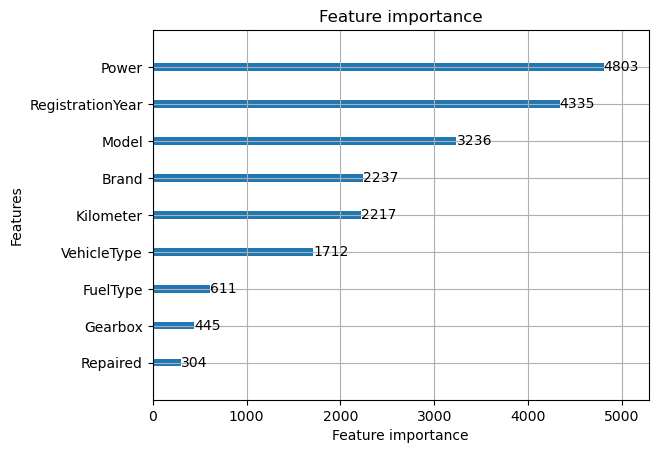

In [55]:
lgbm.plot_importance(model_lgbm_best, height=.2)
plt.show()

##  Conclusion

As a result of the research, the following steps were completed:
- Research and processing of initial data. 
- Model training and their comparison (Linear Regression, LightGBM, CatBoost) in terms of learning speed and prediction, as well as the final RMSE. 
- The best model has been tested on a test sample. 

The LightGMB model showed the best indicators, including an acceptable level of the final RMSE.